In [1]:
#Import the Necessary Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.preprocessing import LabelEncoder



2023-12-03 04:15:33.437111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 04:15:33.437154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 04:15:33.437812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 04:15:33.441843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Parameters
input_size = (224, 224) #Height and Width of the image
batch_size = 32
num_classes = 7  # Number of sentiment classes
epochs = 300  # Adjust as needed



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to preprocess the dataset with data augmentation
def preprocess_dataset(dataset_dir, input_size):
    data = []
    labels = []
    #Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255
    )

    label_encoder = LabelEncoder()

    for emotion_label in os.listdir(dataset_dir):
        emotion_dir = os.path.join(dataset_dir, emotion_label)
        if os.path.isdir(emotion_dir):
            for root, dirs, files in os.walk(emotion_dir):
                for image_file in files:
                    image_path = os.path.join(root, image_file)
                    image = load_img(image_path, target_size=input_size)
                    image = img_to_array(image)
                    
                    if image.shape[-1] != 3:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Converting to Grayscale image
                        image = cv2.equalizeHist(image) #Applying Histogram Equalization
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) #Converting grayscale images to RGB image
                    
                    data.append(image)
                    labels.append(emotion_label)

    labels = label_encoder.fit_transform(labels)
    return np.array(data), labels


In [5]:
from sklearn.model_selection import train_test_split
# Dataset
dataset_dir = '/docker_vm_codes/codes_data/data/KDEF'

# Preprocess the Dataset
X, y = preprocess_dataset(dataset_dir, input_size)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


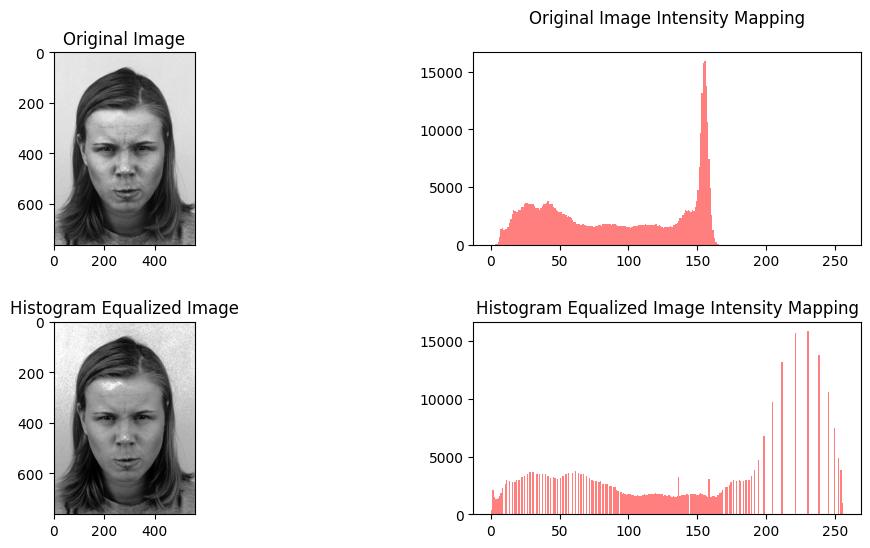

In [6]:
import cv2
import matplotlib.pyplot as plt

# Load original image
img_path = '/docker_vm_codes/codes_data/data/KDEF/angry/0_29.jpg'
original_image = cv2.imread(img_path)

# Convert the image to grayscale if it's a color image
if original_image.shape[-1] == 3:
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization
equalized_image = cv2.equalizeHist(original_image)

# Plot the intensity mapping histograms
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.hist(original_image.ravel(), bins=256, range=[0, 256], color='r', alpha=0.5)
plt.title('Original Image Intensity Mapping\n')

# Histogram Equalized Image
plt.subplot(2, 2, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Histogram Equalized Image')

plt.subplot(2, 2, 4)
plt.hist(equalized_image.ravel(), bins=256, range=[0, 256], color='r', alpha=0.5)
plt.title('Histogram Equalized Image Intensity Mapping')


plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


In [7]:
from tensorflow.keras.utils import to_categorical

# Perform one-hot encoding on y_train, y_val, and y_test
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


# Fine Tuning VGG19 and our Model


In [17]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base models
vgg_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_size + (3,))


# Freeze top layers in base models except the Last two Layers
def freeze_top_layers(base_model):
     for layer in base_model.layers[:-4]:
        layer.trainable = False

freeze_top_layers(vgg_base)

for layer in vgg_base.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: input_2, Trainable: False
Layer Name: block1_conv1, Trainable: False
Layer Name: block1_conv2, Trainable: False
Layer Name: block1_pool, Trainable: False
Layer Name: block2_conv1, Trainable: False
Layer Name: block2_conv2, Trainable: False
Layer Name: block2_pool, Trainable: False
Layer Name: block3_conv1, Trainable: False
Layer Name: block3_conv2, Trainable: False
Layer Name: block3_conv3, Trainable: False
Layer Name: block3_conv4, Trainable: False
Layer Name: block3_pool, Trainable: False
Layer Name: block4_conv1, Trainable: False
Layer Name: block4_conv2, Trainable: False
Layer Name: block4_conv3, Trainable: False
Layer Name: block4_conv4, Trainable: False
Layer Name: block4_pool, Trainable: False
Layer Name: block5_conv1, Trainable: False
Layer Name: block5_conv2, Trainable: True
Layer Name: block5_conv3, Trainable: True
Layer Name: block5_conv4, Trainable: True
Layer Name: block5_pool, Trainable: True


In [18]:
# Function to create transfer model with dropout
def create_transfer_model_with_dropout(base_model, num_classes,dropout_rate=0.1,l2_penalty=0.01):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create transfer models with dropout
vgg_custom_with_dropout = create_transfer_model_with_dropout(vgg_base, num_classes)

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(vgg_custom_with_dropout)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4)


vgg_custom_with_dropout_history = vgg_custom_with_dropout.fit(X_train, y_train, 
                                                       batch_size= batch_size,
                                                       validation_data=(X_val, y_val),
                                                       validation_batch_size=batch_size,
                                                       epochs=epochs, 
                                                       callbacks=[early_stopping])



2023-12-02 10:27:04.384875: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1131970560 exceeds 10% of free system memory.
2023-12-02 10:27:04.859713: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1131970560 exceeds 10% of free system memory.


Epoch 1/300
59/59 [==============================] - 9s 122ms/step - loss: 8.0693 - accuracy: 0.3298 - val_loss: 6.8703 - val_accuracy: 0.5979
Epoch 2/300
59/59 [==============================] - 7s 114ms/step - loss: 6.2448 - accuracy: 0.6574 - val_loss: 5.5429 - val_accuracy: 0.7404
Epoch 3/300
59/59 [==============================] - 7s 114ms/step - loss: 5.0211 - accuracy: 0.7734 - val_loss: 4.5884 - val_accuracy: 0.7809
Epoch 4/300
59/59 [==============================] - 7s 114ms/step - loss: 4.0635 - accuracy: 0.8612 - val_loss: 3.8156 - val_accuracy: 0.8064
Epoch 5/300
59/59 [==============================] - 7s 113ms/step - loss: 3.3385 - accuracy: 0.8926 - val_loss: 3.1091 - val_accuracy: 0.8723
Epoch 6/300
59/59 [==============================] - 7s 115ms/step - loss: 2.7240 - accuracy: 0.9340 - val_loss: 2.8260 - val_accuracy: 0.8298
Epoch 7/300
59/59 [==============================] - 7s 113ms/step - loss: 2.2992 - accuracy: 0.9404 - val_loss: 2.3384 - val_accuracy: 0.8638

In [19]:
#Getting the values for the train loss, validation loss,Training accuracies and validation accuracies
vgg_custom_train_loss = vgg_custom_with_dropout_history.history['loss']
vgg_custom_val_loss = vgg_custom_with_dropout_history.history['val_loss']
vgg_custom_train_acc = vgg_custom_with_dropout_history.history['accuracy']
vgg_custom_val_acc = vgg_custom_with_dropout_history.history['val_accuracy']

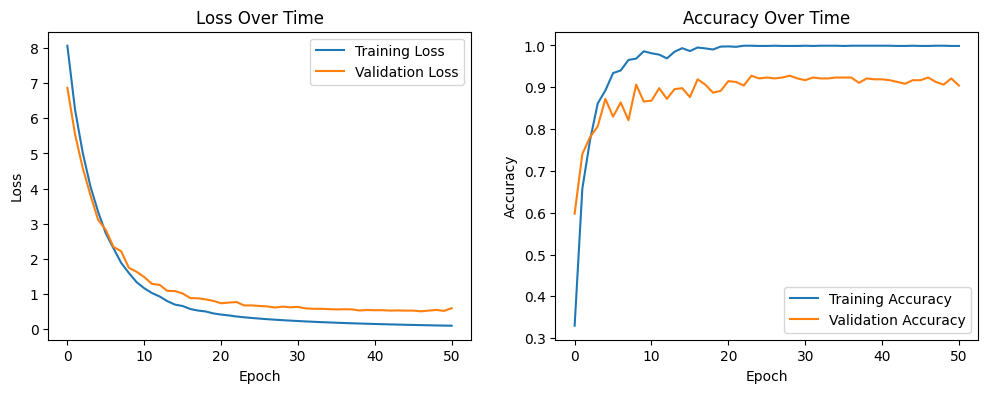

In [20]:
import matplotlib.pyplot as plt

#Plotting the Training and Validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg_custom_train_loss, label='Training Loss')
plt.plot(vgg_custom_val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
#Plotting the Training and Validation Accuracies
plt.subplot(1, 2, 2)
plt.plot(vgg_custom_train_acc, label='Training Accuracy')
plt.plot(vgg_custom_val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')

plt.show()


In [21]:
#Printing the training and the validation accuracies
vgg_custom_train_accuracy = vgg_custom_with_dropout_history.history['accuracy']
vgg_custom_val_accuracy = vgg_custom_with_dropout_history.history['val_accuracy']

print(f"Final Training Accuracy of VGG19: {vgg_custom_train_accuracy[-1]}")
print(f"Final Validation Accuracy of VGG19: {vgg_custom_val_accuracy[-1]}")

Final Training Accuracy of VGG19: 0.9989361763000488
Final Validation Accuracy of VGG19: 0.9042553305625916


In [22]:
# Get model predictions
y_pred = vgg_custom_with_dropout.predict(X_test)

# Convert predictions and true labels from one-hot encoded to categorical
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred_classes))


19/19 [==============================] - 1s 75ms/step
              precision    recall  f1-score   support

           0       0.98      0.88      0.92        90
           1       0.90      0.95      0.93        86
           2       0.89      0.86      0.87        90
           3       0.96      1.00      0.98        81
           4       0.88      0.94      0.91        80
           5       0.88      0.91      0.89        77
           6       0.95      0.90      0.93        84

    accuracy                           0.92       588
   macro avg       0.92      0.92      0.92       588
weighted avg       0.92      0.92      0.92       588



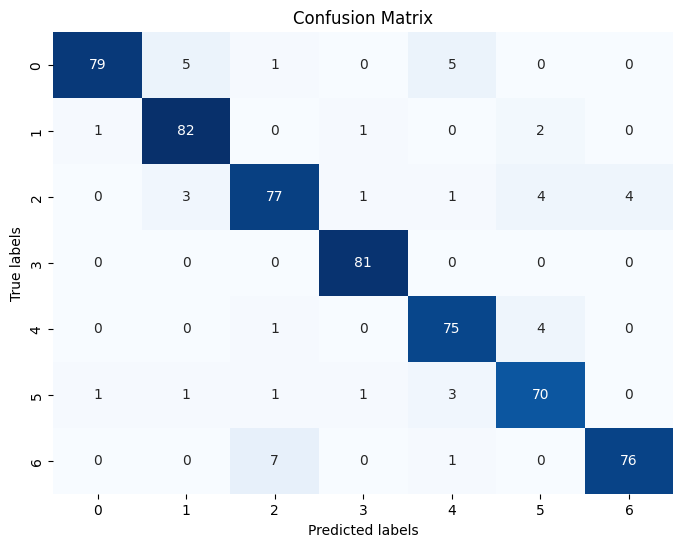

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 16ms/step


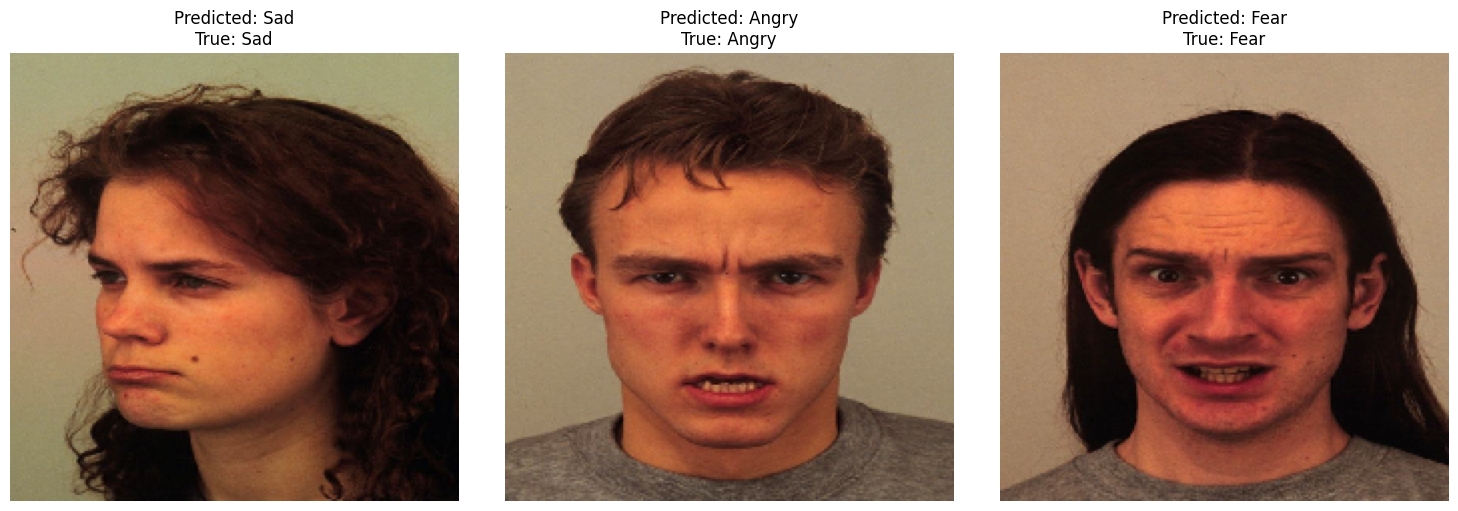

In [24]:
# Predict emotions for three images from the test dataset
num_images_to_predict = 3

# Select three random images from the test set
random_indices = np.random.choice(X_val.shape[0], num_images_to_predict, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]

# Make predictions using the trained model
predictions = vgg_custom_with_dropout.predict(sample_images)

# Define emotion labels based on the numerical classes
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

# Convert predictions and true labels to emotion labels
predicted_emotions = [emotion_labels[np.argmax(pred)] for pred in predictions]
true_emotions = [emotion_labels[np.argmax(label)] for label in sample_labels]

# Normalize the image data to the range [0, 1]
sample_images_normalized = sample_images.astype('float32') / 255.0

# Display the predicted and true labels along with the normalized images
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(15, 5))

for i in range(num_images_to_predict):
    axes[i].imshow(sample_images_normalized[i])  # Display the normalized image
    axes[i].set_title(f"Predicted: {predicted_emotions[i]}\nTrue: {true_emotions[i]}")
    axes[i].axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


In [25]:
test_loss, test_accuracy = vgg_custom_with_dropout.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


19/19 [==============================] - 2s 80ms/step - loss: 0.4470 - accuracy: 0.9184
Test Accuracy: 0.918367326259613


# Our Custom VGG16

In [9]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base models
vgg16_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_size + (3,))


# Freeze top layers in base model accept the last two layers
def freeze_top_layers(base_model):
     for layer in base_model.layers[:-4]: 
        layer.trainable = False

freeze_top_layers(vgg16_base)

for layer in vgg16_base.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: input_2, Trainable: False
Layer Name: block1_conv1, Trainable: False
Layer Name: block1_conv2, Trainable: False
Layer Name: block1_pool, Trainable: False
Layer Name: block2_conv1, Trainable: False
Layer Name: block2_conv2, Trainable: False
Layer Name: block2_pool, Trainable: False
Layer Name: block3_conv1, Trainable: False
Layer Name: block3_conv2, Trainable: False
Layer Name: block3_conv3, Trainable: False
Layer Name: block3_pool, Trainable: False
Layer Name: block4_conv1, Trainable: False
Layer Name: block4_conv2, Trainable: False
Layer Name: block4_conv3, Trainable: False
Layer Name: block4_pool, Trainable: False
Layer Name: block5_conv1, Trainable: True
Layer Name: block5_conv2, Trainable: True
Layer Name: block5_conv3, Trainable: True
Layer Name: block5_pool, Trainable: True


In [54]:
# Function to create transfer model with dropout
def create_transfer_model_with_dropout(base_model, num_classes,dropout_rate=0.1):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create transfer models with dropout
vgg16_custom_with_dropout = create_transfer_model_with_dropout(vgg16_base, num_classes)

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(vgg16_custom_with_dropout)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4)


vgg16_custom_history_with_dropout = vgg16_custom_with_dropout.fit(X_train, y_train, 
                                                       batch_size= batch_size,
                                                       validation_data=(X_val, y_val),
                                                       validation_batch_size=batch_size,
                                                       epochs=epochs, 
                                                       callbacks=[early_stopping])




Epoch 1/300
59/59 [==============================] - 8s 105ms/step - loss: 6.8507 - accuracy: 0.7511 - val_loss: 5.6818 - val_accuracy: 0.8936
Epoch 2/300
59/59 [==============================] - 6s 98ms/step - loss: 4.7677 - accuracy: 0.9819 - val_loss: 4.4391 - val_accuracy: 0.9191
Epoch 3/300
59/59 [==============================] - 6s 98ms/step - loss: 3.7187 - accuracy: 0.9862 - val_loss: 3.6194 - val_accuracy: 0.9064
Epoch 4/300
59/59 [==============================] - 6s 98ms/step - loss: 2.9204 - accuracy: 0.9910 - val_loss: 2.9875 - val_accuracy: 0.9064
Epoch 5/300
59/59 [==============================] - 6s 98ms/step - loss: 2.3136 - accuracy: 0.9910 - val_loss: 2.3721 - val_accuracy: 0.9106
Epoch 6/300
59/59 [==============================] - 6s 98ms/step - loss: 1.8484 - accuracy: 0.9931 - val_loss: 1.9246 - val_accuracy: 0.9191
Epoch 7/300
59/59 [==============================] - 6s 98ms/step - loss: 1.4763 - accuracy: 0.9984 - val_loss: 1.5931 - val_accuracy: 0.9298
Epoch

In [55]:
#Getting the values for the Training loss, validation loss, training accuracy and validation accuracy
vgg16_custom_train_loss = vgg16_custom_history_with_dropout.history['loss']
vgg16_custom_val_loss = vgg16_custom_history_with_dropout.history['val_loss']
vgg16_custom_train_acc = vgg16_custom_history_with_dropout.history['accuracy']
vgg16_custom_val_acc = vgg16_custom_history_with_dropout.history['val_accuracy']

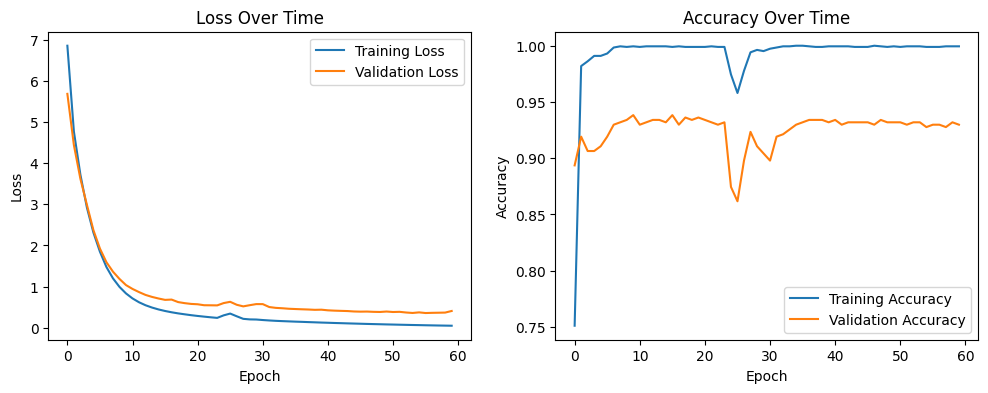

In [56]:
import matplotlib.pyplot as plt
#Plot the figure for the Training loss and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg16_custom_train_loss, label='Training Loss')
plt.plot(vgg16_custom_val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
#Plot the figure for the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(vgg16_custom_train_acc, label='Training Accuracy')
plt.plot(vgg16_custom_val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')

plt.show()


In [57]:
#Printing the final Training and Validation Accuracies
vgg16_custom_train_accuracy = vgg16_custom_history_with_dropout.history['accuracy']
vgg16_custom_val_accuracy = vgg16_custom_history_with_dropout.history['val_accuracy']

print(f"Final Training Accuracy of VGG19: {vgg16_custom_train_accuracy[-1]}")
print(f"Final Validation Accuracy of VGG19: {vgg16_custom_val_accuracy[-1]}")

Final Training Accuracy of VGG19: 0.9994680881500244
Final Validation Accuracy of VGG19: 0.9297872185707092


In [58]:
# Get model predictions
y_pred = vgg16_custom_with_dropout.predict(X_test)

# Convert predictions and true labels from one-hot encoded to categorical
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(y_true, y_pred_classes))


19/19 [==============================] - 1s 64ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        90
           1       0.93      0.97      0.95        86
           2       0.95      0.86      0.90        90
           3       0.99      1.00      0.99        81
           4       0.94      0.95      0.94        80
           5       0.87      0.96      0.91        77
           6       0.94      0.94      0.94        84

    accuracy                           0.94       588
   macro avg       0.94      0.94      0.94       588
weighted avg       0.94      0.94      0.94       588



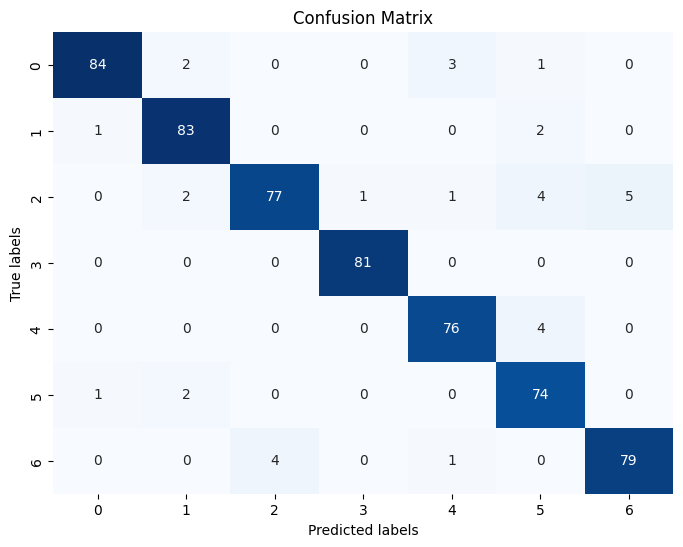

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 15ms/step


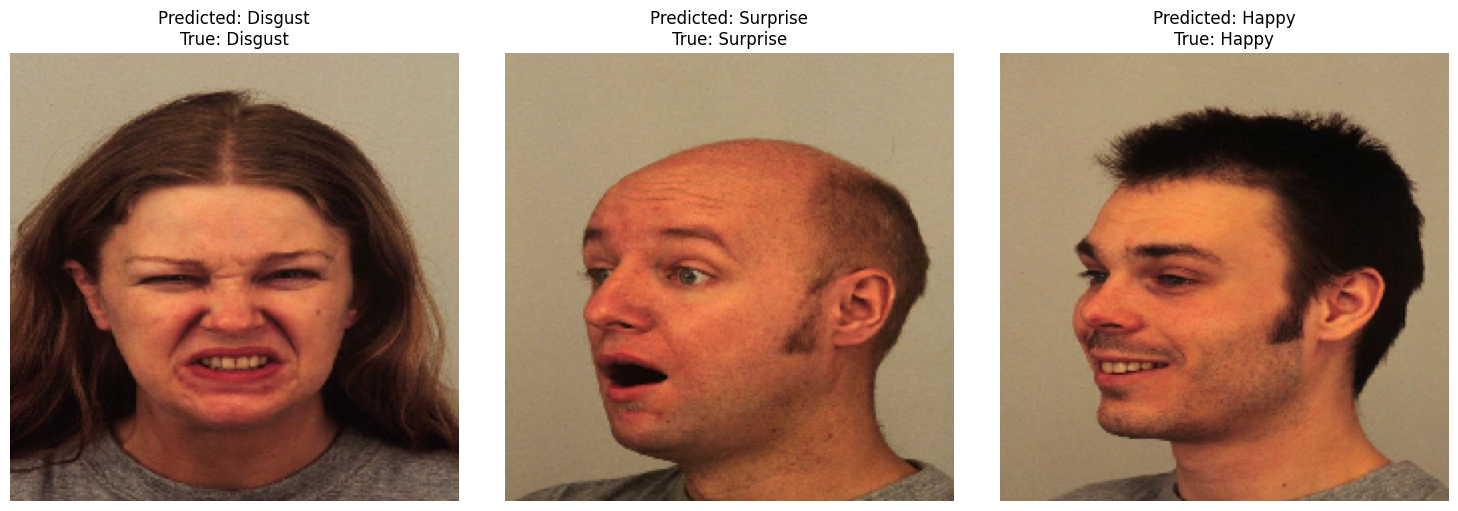

In [52]:
# Predict emotions for three images from the test dataset
num_images_to_predict = 3

# Select three random images from the test set
random_indices = np.random.choice(X_val.shape[0], num_images_to_predict, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]

# Make predictions using the trained model
predictions = vgg16_custom_with_dropout.predict(sample_images)

# Define emotion labels based on the numerical classes
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

# Convert predictions and true labels to emotion labels
predicted_emotions = [emotion_labels[np.argmax(pred)] for pred in predictions]
true_emotions = [emotion_labels[np.argmax(label)] for label in sample_labels]

# Normalize the image data to the range [0, 1]
sample_images_normalized = sample_images.astype('float32') / 255.0

# Display the predicted and true labels along with the normalized images
fig, axes = plt.subplots(1, num_images_to_predict, figsize=(15, 5))

for i in range(num_images_to_predict):
    axes[i].imshow(sample_images_normalized[i])  # Display the normalized image
    axes[i].set_title(f"Predicted: {predicted_emotions[i]}\nTrue: {true_emotions[i]}")
    axes[i].axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


In [60]:
test_loss, test_accuracy = vgg16_custom_with_dropout.evaluate(X_test, y_test)
#vgg16_custom_test_accuracy= test_accuracy
print(f"Test Accuracy: {test_accuracy}")


19/19 [==============================] - 1s 66ms/step - loss: 0.3632 - accuracy: 0.9422
Test Accuracy: 0.942176878452301
